<a href="https://colab.research.google.com/github/ghommidhWassim/GNN-variants/blob/main/graphSAGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!pip install torchvision
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
2.6.0+cu124
12.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 815.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    

In [55]:
# Standard libraries
import numpy as np
from scipy import sparse
import seaborn as sns
import pandas as pd
import time
# Plotting libraries
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
from IPython.display import Javascript  # Restrict height of output cell.

# PyTorch
import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch.nn as nn
from torch_sparse import spmm
# import pyg_lib
import torch_sparse

# PyTorch geometric
from torch_geometric.nn import GCNConv,SAGEConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric import seed_everything
import torch
import os.path as osp
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborLoader


In [79]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def dataset_load():
  print(f"Using device: {device}")
  dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())
  num_features = dataset.num_features
  num_classes = dataset.num_classes
  data = dataset[0].to(device)  # Get the first graph object.
  return num_features, data, num_classes, device,dataset

def clean_gpu_memory():
    """Cleans GPU memory without fully resetting the CUDA context"""
    import gc
    gc.collect()  # Python garbage collection
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # PyTorch cache
        torch.cuda.reset_peak_memory_stats()  # Reset tracking
        print(f"Memory after cleanup: {torch.cuda.memory_allocated()/1024**2:.2f} MB")

num_features, data, num_classes, device, dataset = dataset_load()
print(f'Number of nodes:          {data.num_nodes}')
print(f'Number of edges:          {data.num_edges}')
print(f'Average node degree:      {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Has isolated nodes:       {data.has_isolated_nodes()}')
print(f'Has self-loops:           {data.has_self_loops()}')
print(f'Is undirected:            {data.is_undirected()}')
num_features

Using device: cuda
Number of nodes:          19717
Number of edges:          88648
Average node degree:      4.50
Number of training nodes: 60
Training node label rate: 0.003
Has isolated nodes:       False
Has self-loops:           False
Is undirected:            True


500

In [83]:
print(f"Allocated memory : {torch.cuda.memory_allocated() / (1024**2):.2f} MB")
print(f"Reserved memory : {torch.cuda.memory_reserved() / (1024**2):.2f} MB")
print(f"Peak allocated memory: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB")


Allocated memory : 96.37 MB
Reserved memory : 158.00 MB
Peak allocated memory: 96.37 MB


In [87]:
clean_gpu_memory()

Memory after cleanup: 56.81 MB


In [85]:
train_loader = NeighborLoader(
    data,
    input_nodes=data.train_mask,
    num_neighbors=[10, 10],  # s = 10 per layer (2 layers)
    batch_size=128,
    shuffle=True,
)


In [88]:
print(f"Allocated memory : {torch.cuda.memory_allocated() / (1024**2):.2f} MB")
print(f"Reserved memory : {torch.cuda.memory_reserved() / (1024**2):.2f} MB")
print(f"Peak allocated memory: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB")

Allocated memory : 56.81 MB
Reserved memory : 120.00 MB
Peak allocated memory: 56.81 MB


In [89]:
class testGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout=0.5):
        super().__init__()
        self.num_layers = num_layers
        self.dropout = dropout

        self.convs = torch.nn.ModuleList()
        # First layer: in_channels -> hidden_channels
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        # Intermediate layers: hidden_channels -> hidden_channels
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        # Last layer: hidden_channels -> out_channels (optional, if no linear layers)
        self.convs.append(SAGEConv(hidden_channels, out_channels))

        # Optional MLP head (for further transformation)
        self.lin1 = Linear(out_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = F.relu(conv(x, edge_index))
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Last layer (no ReLU/Dropout for classification)
        x = self.convs[-1](x, edge_index)

        # Optional MLP head
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin2(x)

        return F.log_softmax(x, dim=1)

In [90]:
hidden_channels = 64

model = testGraphSAGE(
    in_channels=dataset.num_features,  # Input feature dimension
    hidden_channels=64,               # Hidden layer size
    num_layers=2,                     # Number of SAGEConv layers
    out_channels=dataset.num_classes,  # Output dimension (number of classes)
    dropout=0.5,                      # Dropout rate                         # Jumping Knowledge (optional: "cat", "max", "lstm")
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()  # Negative Log Likelihood (used with log_softmax)


In [91]:
# Minibatch training function
def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Full-batch evaluation (for simplicity)
def evaluate(mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out[mask].argmax(dim=1)
        acc = (pred == data.y[mask]).float().mean().item()
    return acc

In [92]:
# Training loop
start_time = time.time()

allocated_mem = []
reserved_mem = []
peak_mem = []
for epoch in range(1, 101):
    #torch.cuda.reset_peak_memory_stats()  # reset peak tracking
    loss = train()
    val_acc = evaluate(data.val_mask)
    print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}")

    alloc = torch.cuda.memory_allocated() / 1024**2
    reserv = torch.cuda.memory_reserved() / 1024**2
    peak = torch.cuda.max_memory_allocated() / 1024**2

    allocated_mem.append(alloc)
    reserved_mem.append(reserv)
    peak_mem.append(peak)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Test accuracy
test_acc = evaluate(data.test_mask)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch: 001, Loss: 1.1076, Val Acc: 0.4160
Epoch: 002, Loss: 1.0959, Val Acc: 0.4260
Epoch: 003, Loss: 1.0954, Val Acc: 0.6000
Epoch: 004, Loss: 1.1024, Val Acc: 0.5920
Epoch: 005, Loss: 1.1329, Val Acc: 0.5420
Epoch: 006, Loss: 1.0844, Val Acc: 0.5420
Epoch: 007, Loss: 1.1066, Val Acc: 0.6040
Epoch: 008, Loss: 1.0371, Val Acc: 0.4500
Epoch: 009, Loss: 1.0534, Val Acc: 0.4340
Epoch: 010, Loss: 1.0380, Val Acc: 0.4820
Epoch: 011, Loss: 1.0007, Val Acc: 0.5760
Epoch: 012, Loss: 0.9730, Val Acc: 0.6380
Epoch: 013, Loss: 0.9670, Val Acc: 0.6200
Epoch: 014, Loss: 0.9097, Val Acc: 0.6200
Epoch: 015, Loss: 0.8417, Val Acc: 0.6160
Epoch: 016, Loss: 0.7736, Val Acc: 0.6160
Epoch: 017, Loss: 0.7087, Val Acc: 0.6280
Epoch: 018, Loss: 0.6131, Val Acc: 0.6680
Epoch: 019, Loss: 0.6066, Val Acc: 0.7000
Epoch: 020, Loss: 0.5433, Val Acc: 0.6740
Epoch: 021, Loss: 0.5763, Val Acc: 0.6300
Epoch: 022, Loss: 0.5136, Val Acc: 0.6300
Epoch: 023, Loss: 0.4810, Val Acc: 0.6320
Epoch: 024, Loss: 0.4742, Val Acc:

In [62]:
test_acc = evaluate(data.test_mask)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.7500


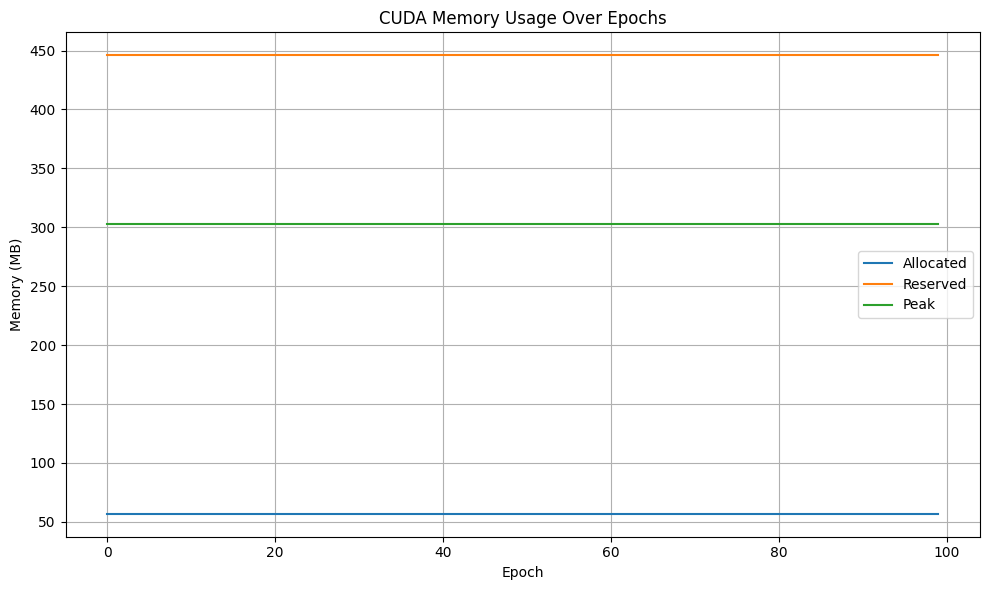

In [70]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(allocated_mem, label='Allocated')
plt.plot(reserved_mem, label='Reserved')
plt.plot(peak_mem, label='Peak')
plt.xlabel('Epoch')
plt.ylabel('Memory (MB)')
plt.title('CUDA Memory Usage Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [75]:
import math

def calculate_graphsage_memory(
    num_layers: int,
    hidden_dim: int,
    num_classes: int,
    batch_size: int,
    num_neighbors: list,
    dtype_bytes: int = 4,  # float32=4, float16=2
    verbose: bool = True
) -> dict:
    """
    Calculate memory usage for GraphSAGE based on:
    - Weight matrices: O(LK²)
    - Intermediate embeddings: Batch size × Neighbor fanout × Hidden dim

    Args:
        num_layers: Number of SAGEConv layers (L)
        hidden_dim: Hidden dimension size (K)
        num_classes: Output dimension size (C)
        batch_size: Number of seed nodes (B)
        num_neighbors: List of neighbors per layer (e.g., [25, 10] for 2 layers)
        dtype_bytes: Bytes per parameter (4 for float32, 2 for float16)
        verbose: Print detailed breakdown

    Returns:
        Dictionary with memory components in MB
    """
    # --- Weight Matrices (O(LK²)) ---
    # Input-to-hidden: K×K
    # Hidden-to-output: K×C
    weight_memory = (num_layers * hidden_dim**2 + hidden_dim * num_classes) * dtype_bytes
    weight_memory_mb = weight_memory / (1024 ** 2)

    # --- Intermediate Embeddings ---
    # Layer 0: seed nodes
    current_nodes = batch_size
    embedding_memory = 0

    for l in range(num_layers):
        # Nodes in this layer = current_nodes × neighbors[l]
        current_nodes *= num_neighbors[l]
        # Memory = nodes × hidden_dim × bytes
        layer_memory = current_nodes * hidden_dim * dtype_bytes
        embedding_memory += layer_memory

        if verbose:
            print(f"Layer {l+1}: {current_nodes:,} nodes → {layer_memory/(1024**2):.2f} MB")

    embedding_memory_mb = embedding_memory / (1024 ** 2)

    # --- Total ---
    total_memory_mb = weight_memory_mb + embedding_memory_mb

    if verbose:
        print("\nMemory Breakdown:")
        print(f"- Weights:    {weight_memory_mb:.4f} MB")
        print(f"- Embeddings: {embedding_memory_mb:.2f} MB")
        print(f"Total:       {total_memory_mb:.2f} MB")

    return {
        'weights_mb': weight_memory_mb,
        'embeddings_mb': embedding_memory_mb,
        'total_mb': total_memory_mb,
        'peak_nodes': current_nodes
    }

# Example usage for PubMed dataset
if __name__ == "__main__":
    config = {
        'num_layers': 2,
        'hidden_dim': 64,
        'num_classes': num_classes,
        'batch_size': 128,
        'num_neighbors': [10, 10],
        'dtype_bytes': 4  # float32
    }

    memory_stats = calculate_graphsage_memory(**config)

Layer 1: 1,280 nodes → 0.31 MB
Layer 2: 12,800 nodes → 3.12 MB

Memory Breakdown:
- Weights:    0.0320 MB
- Embeddings: 3.44 MB
Total:       3.47 MB


In [76]:
from torch.profiler import profile, record_function, ProfilerActivity

def profile_memory_usage(model, data_loader):
    with profile(
        activities=[ProfilerActivity.CUDA],  # Track CUDA memory
        profile_memory=True,
        record_shapes=True
    ) as prof:
        for batch in data_loader:
            with record_function("forward_pass"):
                out = model(batch.x, batch.edge_index)
            with record_function("backward_pass"):
                loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
                loss.backward()

    # Print memory summary
    print(prof.key_averages().table(sort_by="cuda_memory_usage", row_limit=10))

In [94]:
print(f"Allocated memory : {torch.cuda.memory_allocated() / (1024**2):.2f} MB")
print(f"Reserved memory : {torch.cuda.memory_reserved() / (1024**2):.2f} MB")
print(f"Peak allocated memory: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB")


Allocated memory : 56.81 MB
Reserved memory : 368.00 MB
Peak allocated memory: 302.89 MB


In [65]:
summ=torch.cuda.memory_summary()

In [66]:
summ

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  58174 KiB | 438032 KiB | 266154 MiB | 266097 MiB |\n|       from large pool |  56937 KiB | 434194 KiB | 256130 MiB | 256074 MiB |\n|       from small pool |   1237 KiB |   6679 KiB |  10024 MiB |  10023 MiB |\n|---------------------------------------------------------------------------|\n| Active memory         |  58174 KiB | 438032 KiB | 266154 MiB | 266097 MiB |\n|       from large pool |  56937 KiB | 434194 KiB |

In [ ]:
peak_memory_mb=f"{torch.cuda.max_memory_allocated()/1024**2:.2f}"
total_train_time=f"{end_time - start_time:.2f}"
import json

metrics = {
    "model": "graphSAGE",
    "accuracy": "0.7200",
    "memory_MB": peak_memory_mb,
    "train_time_sec": total_train_time
}

with open("graphSAGE_results.json", "w") as f:
    json.dump(metrics, f)

In [ ]:
def calc_graphsage_memory_requirements(batch_size, fanout, num_layers, hidden_dim):
    bytes_per_float = 4

    # Total number of unique nodes sampled for 1 batch (approx)
    total_sampled_nodes = batch_size * (fanout ** (num_layers - 1))

    # Embedding memory for all sampled nodes
    intermediate_embeddings = total_sampled_nodes * hidden_dim * bytes_per_float

    # Weight matrices: L layers of KxK
    weight_params = num_layers * hidden_dim * hidden_dim * bytes_per_float

    total = intermediate_embeddings + weight_params

    return {
        "intermediate_embeddings_MB": intermediate_embeddings / 1024**2,
        "weight_matrices_MB": weight_params / 1024**2,
        "total_MB": total / 1024**2
    }

# Example values:
batch_size = 128
fanout = 10
num_layers = 2
hidden_dim = 64

mem_usage = calc_graphsage_memory_requirements(batch_size, fanout, num_layers, hidden_dim)

print(f"Intermediate Embeddings: {mem_usage['intermediate_embeddings_MB']:.2f} MB")
print(f"Weight Matrices        : {mem_usage['weight_matrices_MB']:.2f} MB")
print(f"Total Estimated        : {mem_usage['total_MB']:.2f} MB")
